## Evaluating Jazz album prices on Discogs.com
### Data Analysis
**- program:** 03_analysis.ipynb<br>
**- purpose:** readin clean .csv output from 02_dataprep <br>
**- date:** jan 17, 2021<br>
**- created by:** chris chan<br>
**- Methods:**
    - EDA<br>
    - OLS<br>
    - CV for Model Selection<br>
    - Train, Val, Test data<br>
    <br>
- Buyer/seller marketplaces are intersting to track because you would typically think it's a supply demand model. The marketplace for collectibles varies a bit more. Vinyl has experienced a resurgence in the past several years, even in the midst of digital platforms (spotify) and easy access to music. I'm not trying to answer the question why there is a resurgence but rather given the expansion (and continual expansion) of this space, more people are intersted in buying and selling and hence should have some understanding of factors that go into the price.**

**Important sites re: LR, Lasso, Ridge**<br>

**- Coef interprestations:**
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

**- Column Transformer:**
https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
https://github.com/allisonhonold/column_transformer_ferry_wait_blog/blob/master/columntransformer_example.ipynb
https://towardsdatascience.com/using-columntransformer-to-combine-data-processing-steps-af383f7d5260

**- Cross Val:**
https://scikit-learn.org/stable/modules/cross_validation.html

**- Mixed: Cat/Cont**
https://stats.stackexchange.com/questions/463690/multiple-regression-with-mixed-continuous-categorical-variables-dummy-coding-s

**- OHE**
https://stackoverflow.com/questions/31506987/scikit-learn-one-hot-encode-before-or-after-train-test-split

**- Residual Plots**
https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

**- Predictions**
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

**- LR/Lasso/Ridge:**
https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn
https://machinelearningmastery.com/lasso-regression-with-python/

**- Grid Search:**
https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

## 1. Pre Processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score


Populating the interactive namespace from numpy and matplotlib


**Read-in clean dataframe**

In [2]:
df=pd.read_csv(r'../data/clean/_df_clean.csv')
df.head(3)

Label Country Genre Release_Date          Style  fpress  \
0  Blue Note – BLP 1502      US  Jazz     Feb 1956  Hard Bop, Bop       1   
1  Blue Note – BLP 1567      US  Jazz         1957       Hard Bop       0   
2  Blue Note – BLP 1508      US  Jazz     May 1956       Hard Bop       1   

   spress  tpress  original  rare  ...  recyear  rating  votes  haves  wants  \
0       0       0         1     0  ...       56    4.32   25.0  219.0  301.0   
1       0       0         0     0  ...       57    4.50   16.0   68.0  385.0   
2       0       0         1     0  ...       56    4.62   29.0  206.0  411.0   

  sleeve_cond_abbr media_cond_abbr seller_rating  media_cond_num  \
0               VG             VG+         0.988               6   
1               VG              VG         1.000               5   
2              VG+        NM or M-         0.988               7   

   sleeve_cond_num  
0                5  
1                5  
2                6  

[3 rows x 28 columns]

In [135]:
df.shape

(6981, 28)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6981 entries, 0 to 6980
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Label             6981 non-null   object 
 1   Country           6981 non-null   object 
 2   Genre             6981 non-null   object 
 3   Release_Date      6981 non-null   object 
 4   Style             6981 non-null   object 
 5   fpress            6981 non-null   int64  
 6   spress            6981 non-null   int64  
 7   tpress            6981 non-null   int64  
 8   original          6981 non-null   int64  
 9   rare              6981 non-null   int64  
 10  dgroove           6981 non-null   int64  
 11  sealed            6981 non-null   int64  
 12  promo             6981 non-null   int64  
 13  xnotes            6981 non-null   int64  
 14  price             6981 non-null   float64
 15  artist            6981 non-null   object 
 16  album             6981 non-null   object 


In [137]:
df.describe()
df.describe().to_excel("desc_stats.xlsx")

**Pair Plot on numeric FULL DF**

In [4]:
df_pair=df.drop(['fpress','spress','tpress','original','rare','sealed','dgroove','promo','xnotes'],axis=1)

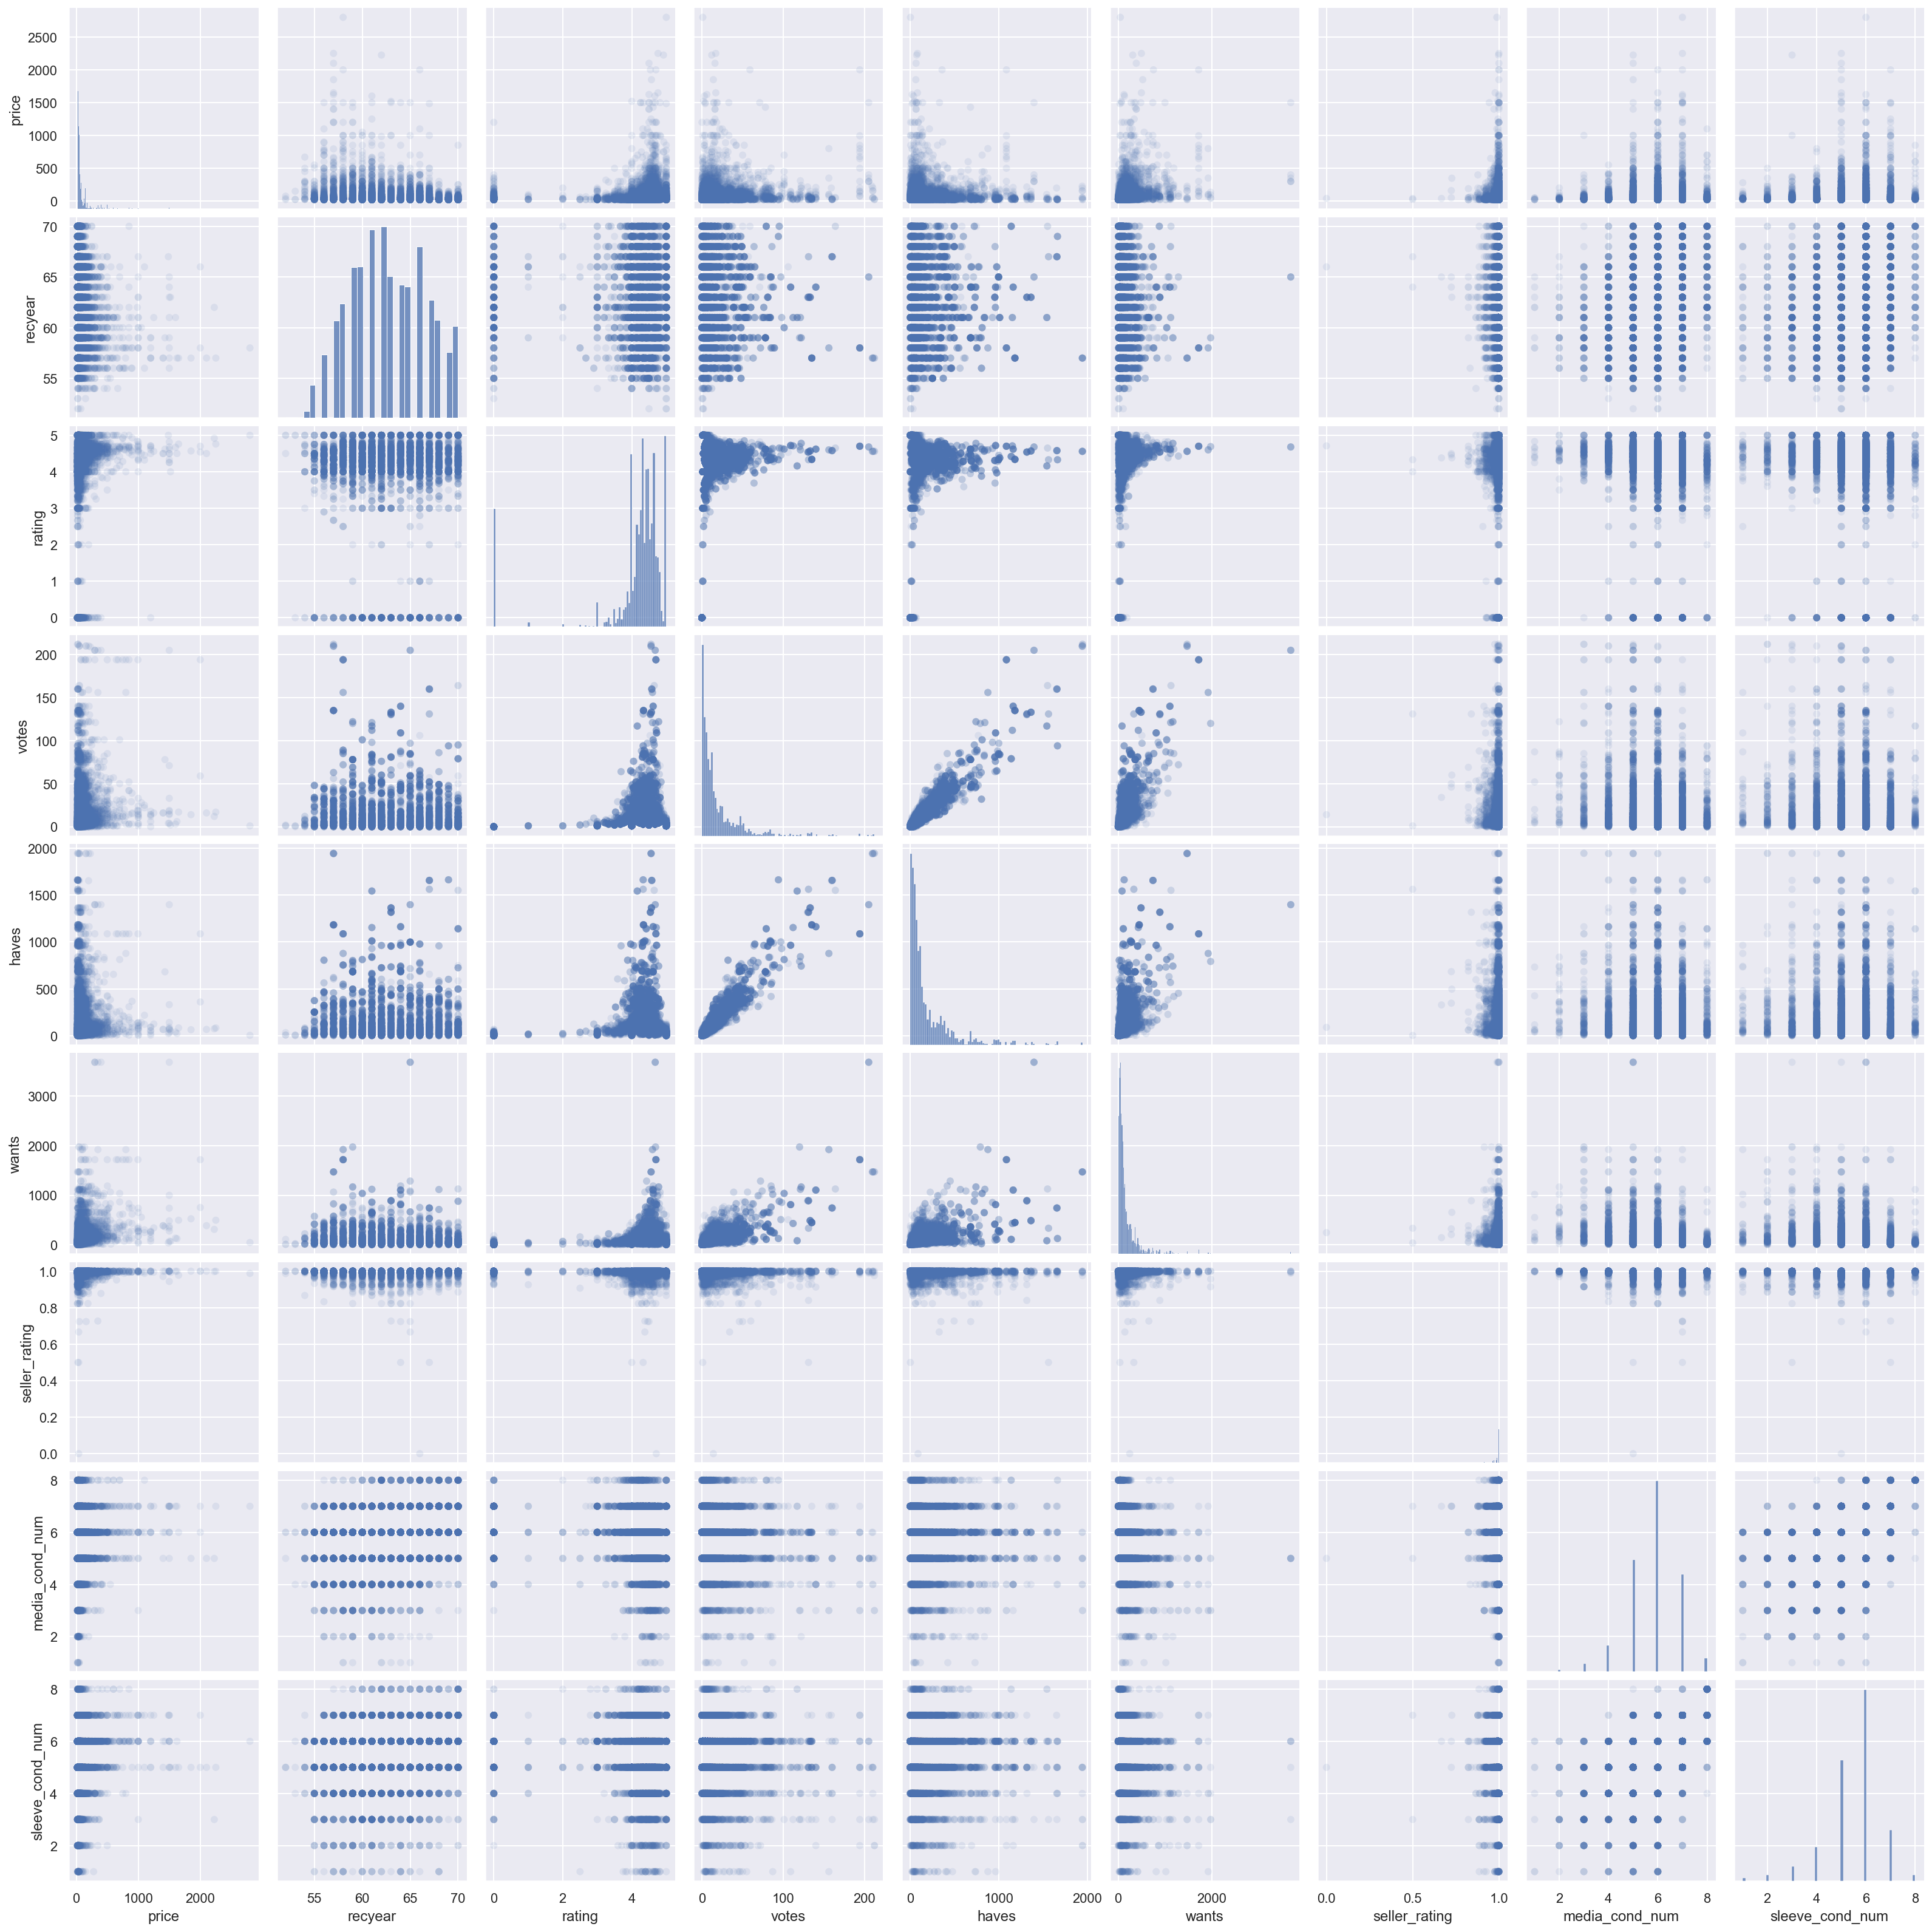

In [5]:
sns.pairplot(df_pair,plot_kws=dict(alpha=.1,edgecolor='none'))
plt.savefig('pairplot.png')

**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price
- maybe change year to categorical
- group F and P sleeve/media ratings

**Check for correlated variables**

In [7]:
df_corr = df.corr()
#df_corr

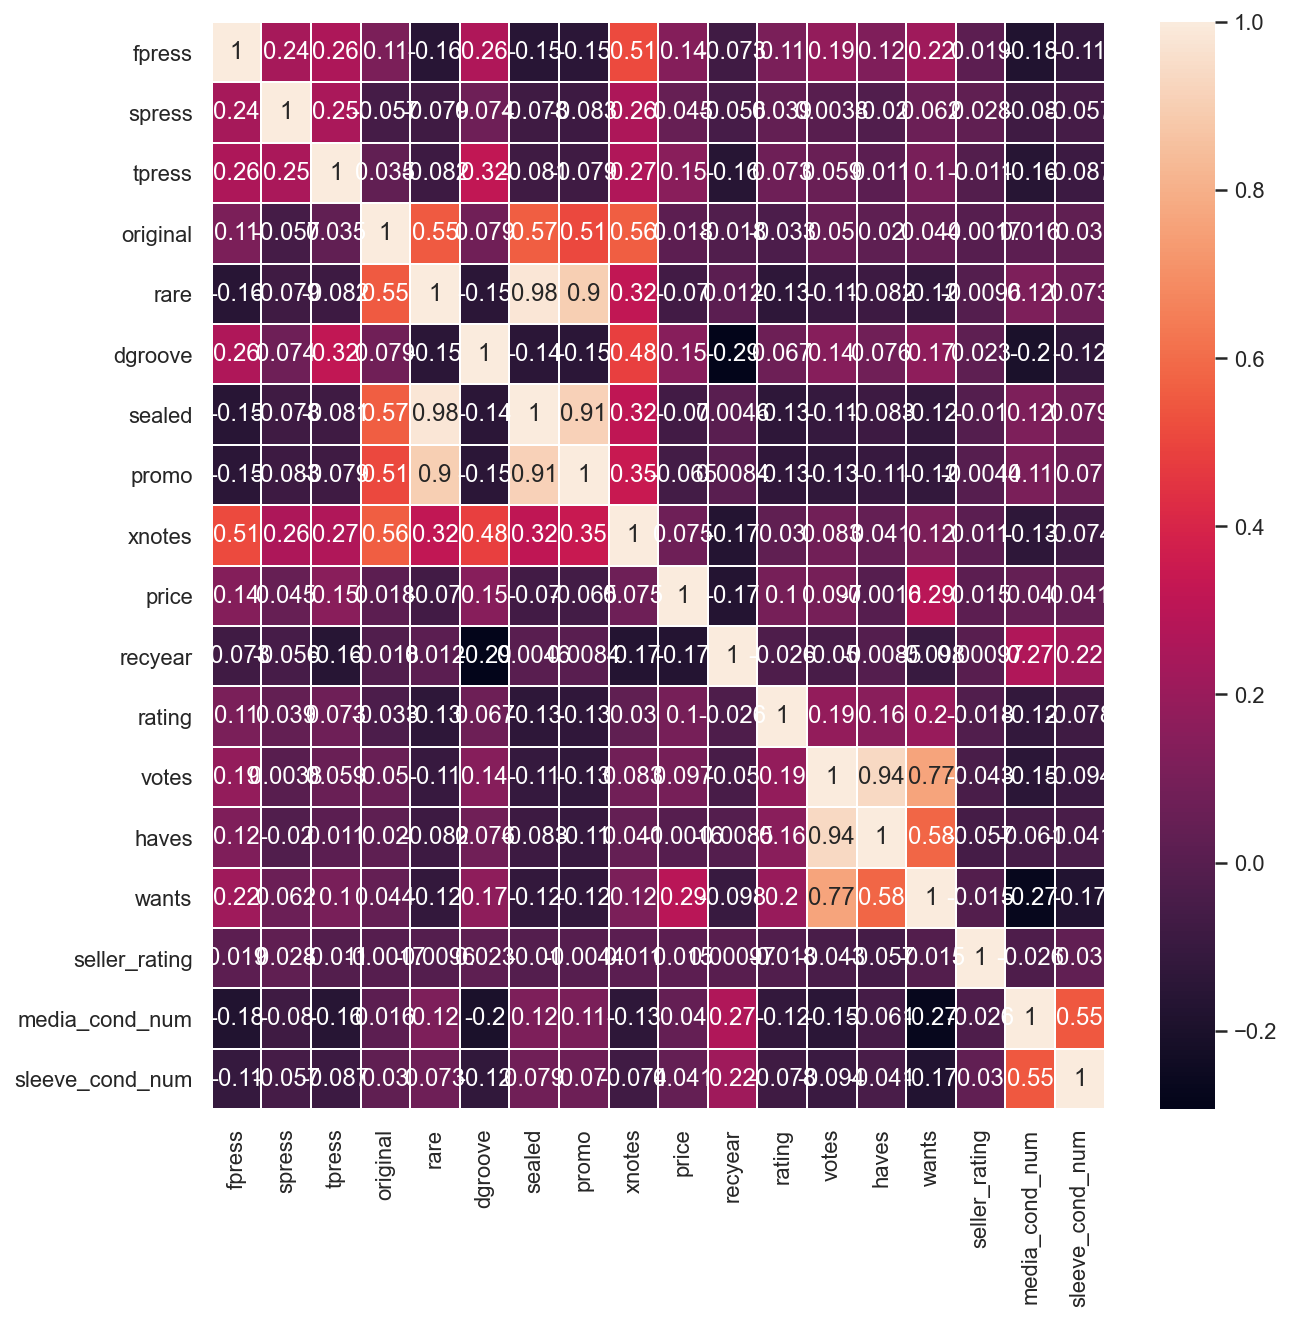

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_corr,  annot=True ,linewidths=.5, ax=ax ) ,
plt.savefig('heatmap.png')

**Crosstab Function**

In [10]:
def xtab(fieldname):
    lab_tab=df[fieldname].value_counts(ascending=False)
    lab_tab2=df[fieldname].value_counts(ascending=False,normalize=True)
    
    print(lab_tab.head(30),lab_tab2.head(30))
    
    # lab_tab = pd.crosstab(index=df["reclabel"],  # Make a crosstab
    #                               columns="count")
    # lab_tab.sort_values('reclabel', ascending=False,inplace=True)

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

**Price Hist**

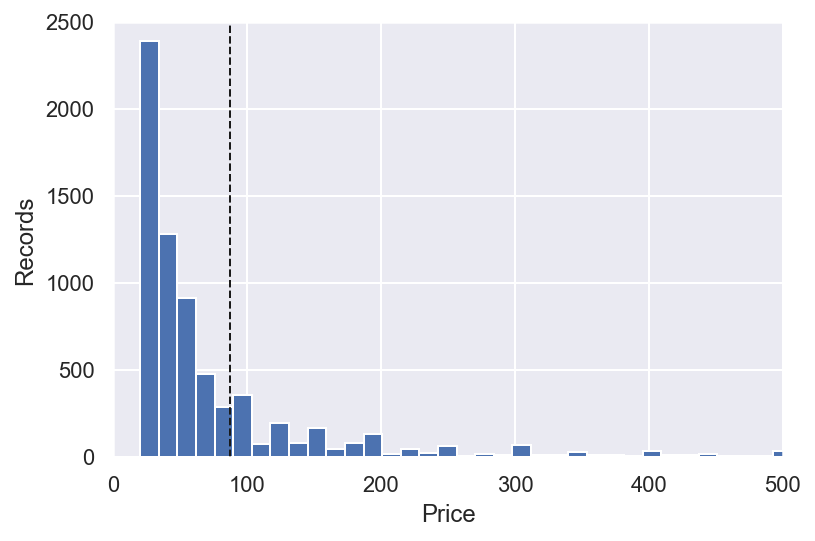

In [142]:
# Price
plt.hist(df['price'], bins =200)
plt.xlim(0,500)
plt.ylim(0,2500)
plt.xlabel('Price'),plt.ylabel('Records')
plt.axvline(df['price'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

**Album Rating Hist**

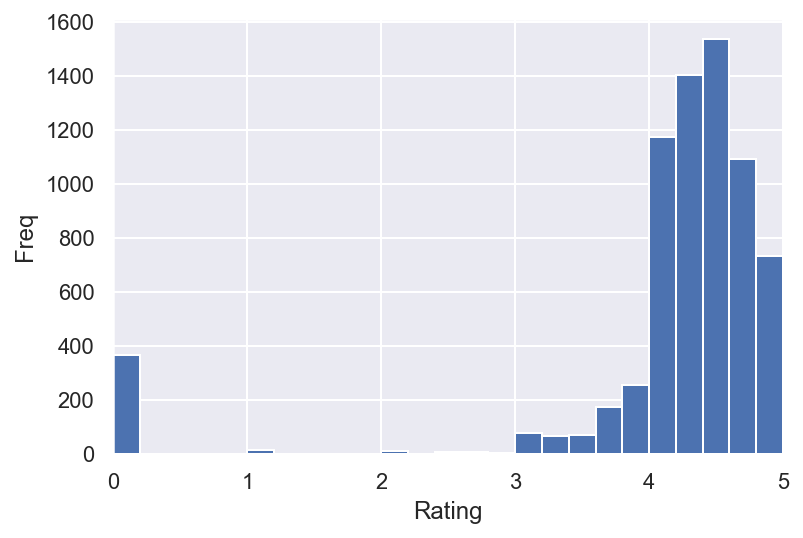

In [143]:
# rating
plt.hist(df['rating'], bins =25)
plt.xlim(0,5,0.5)
plt.xlabel('Rating'),plt.ylabel('Freq')
plt.show()

**Seller Rating Hist**

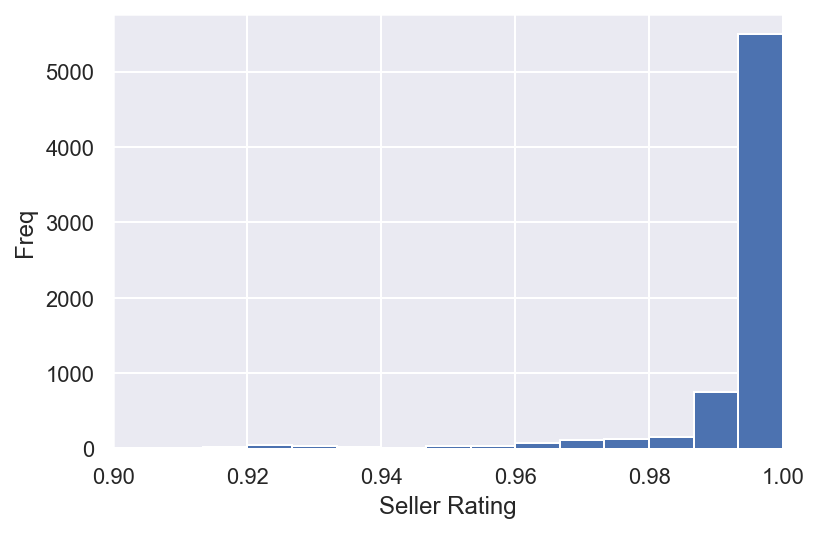

In [144]:
# seller rating
plt.hist(df['seller_rating'], bins =150)
plt.xlabel('Seller Rating'),plt.ylabel('Freq')
plt.xlim(0.9,1.0)
plt.show()

**Record Year**

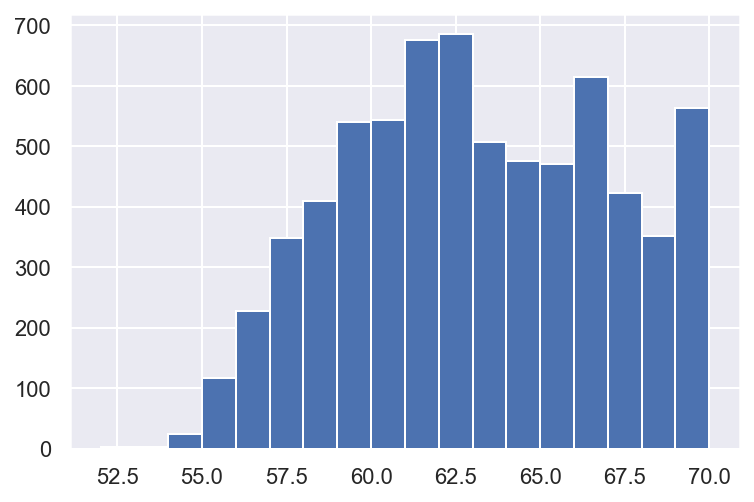

In [145]:
# record year
plt.hist(df['recyear'], bins =18)
#plt.xlim(0,800)
plt.show()

**Age is not necessarily a major factor in record price**<br>
**Therefore create categorical year**

In [146]:
df['recyearfull'] = '19'+ df['recyear'].astype(str)

In [147]:
df['recyearfull'].astype(int)

0       1956
1       1957
2       1956
3       1957
4       1961
        ... 
6976    1958
6977    1961
6978    1960
6979    1966
6980    1970
Name: recyearfull, Length: 6981, dtype: int64

**Bin Labels: Group < 100 to OTher**

In [114]:
xtab('reclabel')

Blue Note                  1660
Prestige                    942
Columbia                    772
Riverside Records           569
Atlantic                    395
Impulse!                    359
Verve Records               302
Vee Jay Records             103
New Jazz                     99
Contemporary Records         90
RCA Victor                   89
EmArcy                       88
Mercury                      87
Argo (6)                     77
Jazzland                     69
Pacific Jazz                 62
United Artists Records       61
JAZZLAND                     51
CBS                          46
World Pacific Records        46
Epic                         45
Capitol Records              41
Fontana                      38
Savoy Records                33
United Artists Jazz          28
A&M Records                  27
Emarcy                       27
Supraphon                    26
Fantasy                      25
Charlie Parker Records       25
Name: reclabel, dtype: int64 Blue Note  

In [148]:
df['labcount']=df.groupby(["reclabel"])["reclabel"].transform('count')
df.loc[df['labcount'] > 75, 'reclabel2'] = df['reclabel']
df.loc[df['labcount'] <=75,   'reclabel2'] = 'Other'
df.head(2)

Label Country Genre Release_Date          Style  fpress  \
0  Blue Note – BLP 1502      US  Jazz     Feb 1956  Hard Bop, Bop       1   
1  Blue Note – BLP 1567      US  Jazz         1957       Hard Bop       0   

   spress  tpress  original  rare  ...  haves  wants  sleeve_cond_abbr  \
0       0       0         1     0  ...  219.0  301.0                VG   
1       0       0         0     0  ...   68.0  385.0                VG   

   media_cond_abbr  seller_rating media_cond_num sleeve_cond_num recyearfull  \
0              VG+          0.988              6               5        1956   
1               VG          1.000              5               5        1957   

   labcount   reclabel2  
0      1660  Blue Note   
1      1660  Blue Note   

[2 rows x 31 columns]

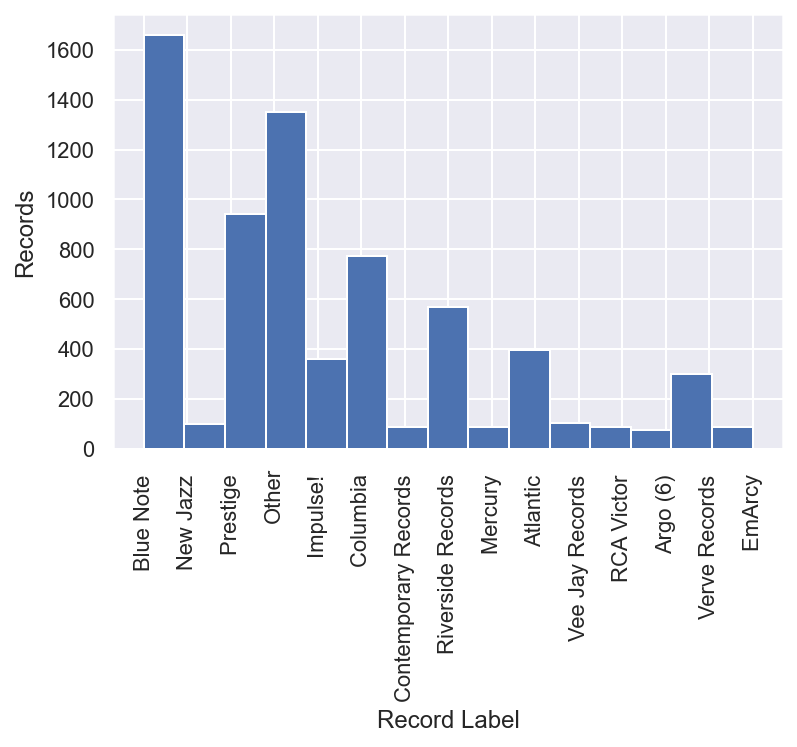

In [197]:
# hist of record label
plt.hist(df['reclabel2'], bins =15)
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.xlabel('Record Label')
plt.ylabel('Records')
plt.show()

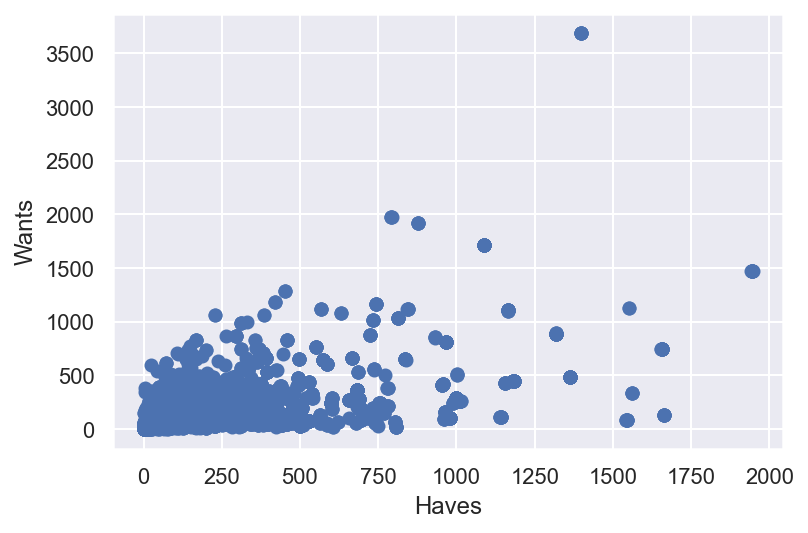

In [152]:
# haves / wants
plt.scatter(df['haves'],df['wants'])
plt.xlabel('Haves')
plt.ylabel('Wants')
plt.show()

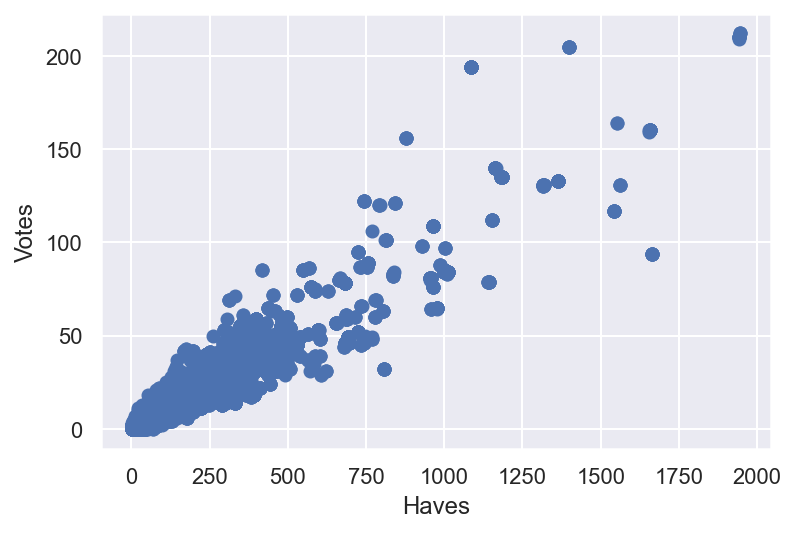

In [153]:
# haves / wants
plt.scatter(df['haves'],df['votes'])
plt.xlabel('Haves')
plt.ylabel('Votes')
plt.show()

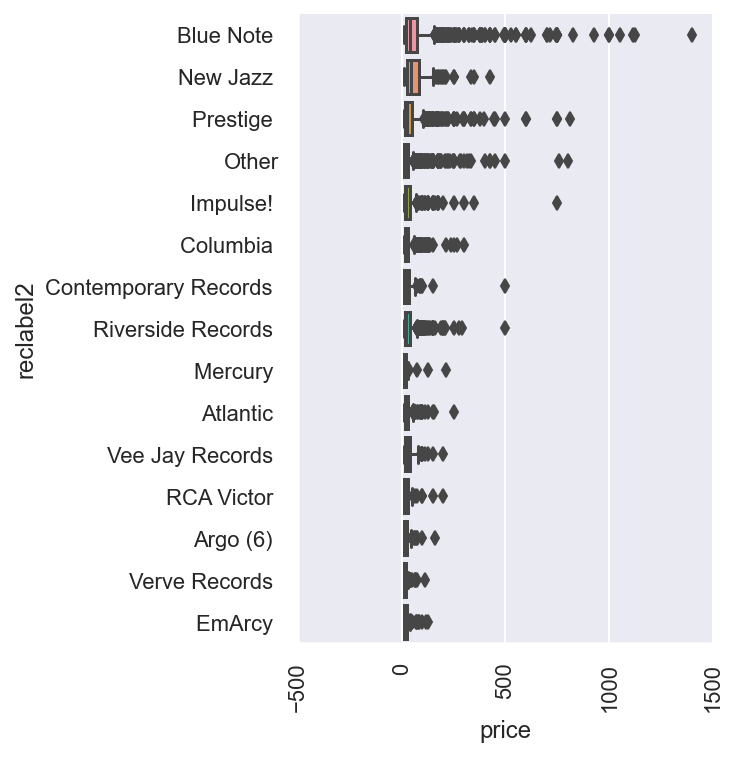

<Figure size 576x576 with 0 Axes>

In [234]:
sns.color_palette("light:b", as_cmap=True)
#g=sns.catplot(data=df,x='reclabel2',y='price',kind='box')
g=sns.catplot(data=df,x='price',y='reclabel2',kind='box')
plt.figure(figsize=(8,8))
g.set_xticklabels(rotation=90)

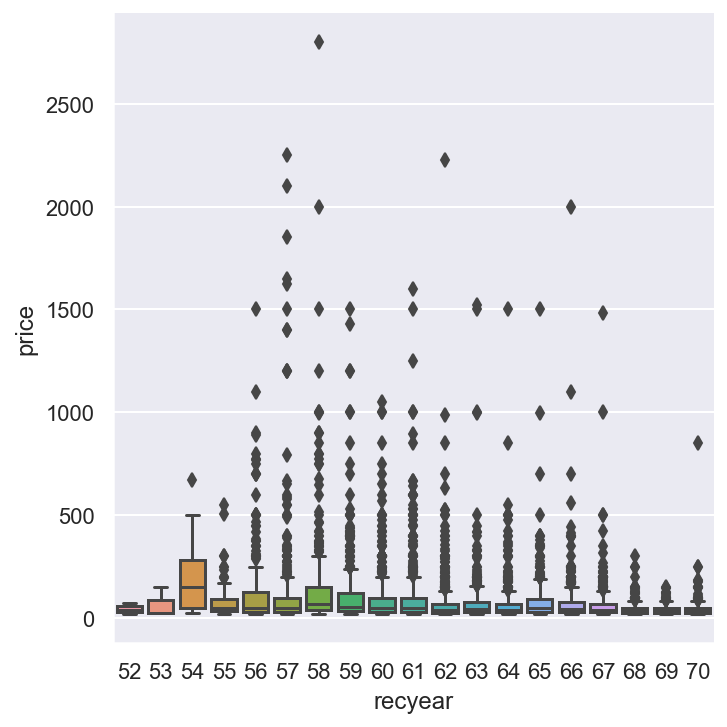

In [79]:
sns.color_palette("light:b", as_cmap=True)
sns.catplot(data=df,x='recyear',y='price',kind='box')


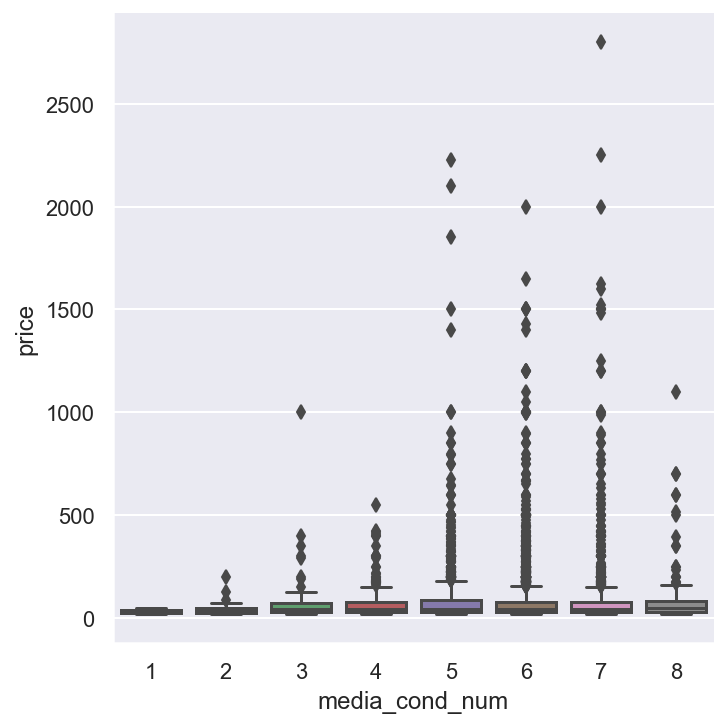

In [22]:
sns.catplot(data=df,x='media_cond_num',y='price',kind='box')

**Country: may need to drop**

**Genre: drop**

In [154]:
# Media/sleeve
xtab('media_cond_num')

6    2958
5    1734
7    1509
4     410
8     206
3     122
2      34
1       8
Name: media_cond_num, dtype: int64 6    0.423722
5    0.248388
7    0.216158
4    0.058731
8    0.029509
3    0.017476
2    0.004870
1    0.001146
Name: media_cond_num, dtype: float64


**Artist/Album**

In [155]:
xtab('album')

 Seven Steps To Heaven                            53
 Miles Davis At Carnegie Hall                     52
 Time Out                                         48
 Somethin' Else                                   47
 Blowin' The Blues Away                           46
 Miles Davis In Europe                            45
 Monk's Dream                                     44
 Drum Suite                                       42
 Miles & Monk At Newport                          41
 The Sidewinder                                   40
 Someday My Prince Will Come                      38
 Jazz Track                                       37
 At Town Hall                                     37
 Doin' The Thing - At The Village Gate            35
 'Round About Midnight                            33
 The Cape Verdean Blues                           33
 My Favorite Things                               32
 Mingus Ah Um                                     32
 Miles Davis And The Modern Jazz Giants       

**Media and Sleeve conditions**

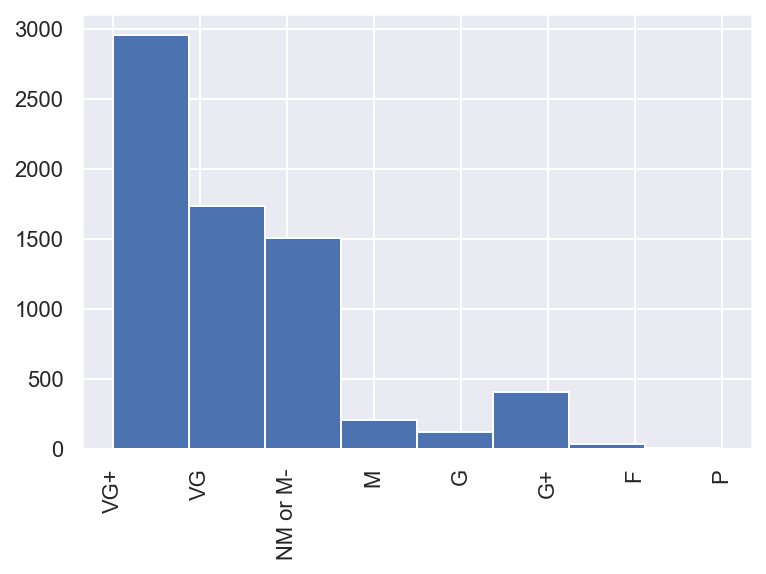

In [156]:
# hist of record label
plt.hist(df['media_cond_abbr'], bins =8)
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.show()

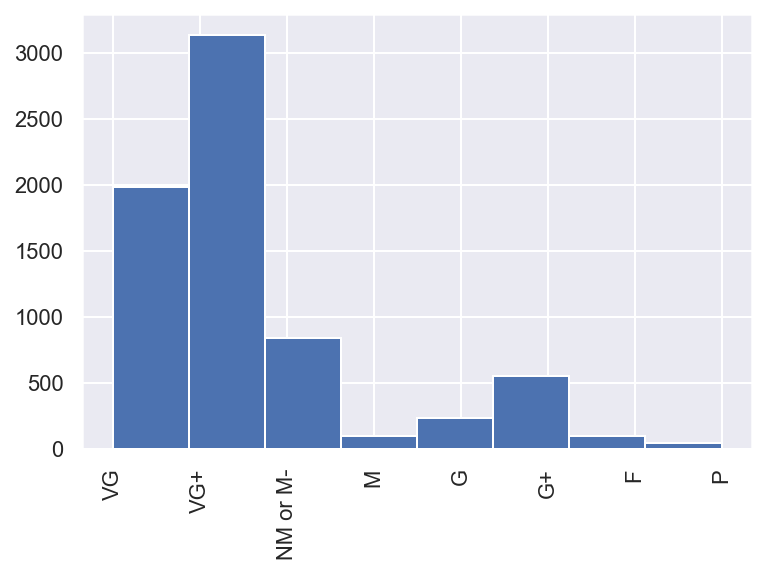

In [157]:
# sleeve
plt.hist(df['sleeve_cond_abbr'], bins =8)
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.show()

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6981 entries, 0 to 6980
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Label             6981 non-null   object 
 1   Country           6981 non-null   object 
 2   Genre             6981 non-null   object 
 3   Release_Date      6981 non-null   object 
 4   Style             6981 non-null   object 
 5   fpress            6981 non-null   int64  
 6   spress            6981 non-null   int64  
 7   tpress            6981 non-null   int64  
 8   original          6981 non-null   int64  
 9   rare              6981 non-null   int64  
 10  dgroove           6981 non-null   int64  
 11  sealed            6981 non-null   int64  
 12  promo             6981 non-null   int64  
 13  xnotes            6981 non-null   int64  
 14  price             6981 non-null   float64
 15  artist            6981 non-null   object 
 16  album             6981 non-null   object 


<br>

## 2. Split Train/Val vs. Test: (80/20)

**Drop cat vars that are not necessary**

In [159]:
# DRop other categorical vars that may not be useful for modeling
df2=df.drop(['reclabel','Country','Label','Genre','Release_Date','Style','artist','album','labcount','rare',
             'fpress','spress','tpress','original','sealed','promo','dgroove',
             'media_cond_abbr','sleeve_cond_abbr', 
             'recyearfull'], axis=1 ) #, inplace=True)
print(df2.columns)

Index(['xnotes', 'price', 'recyear', 'rating', 'votes', 'haves', 'wants',
       'seller_rating', 'media_cond_num', 'sleeve_cond_num', 'reclabel2'],
      dtype='object')


In [ ]:
## Create your dummies prior to split

In [160]:
# on the X_, y_ use OHE since you need integers for model
df3 = pd.get_dummies(df2,drop_first=True)

In [161]:
X , y = df3.drop('price',axis=1), df3['price']
print(X.columns)
print(X.shape,y.shape)

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=35)

Index(['xnotes', 'recyear', 'rating', 'votes', 'haves', 'wants',
       'seller_rating', 'media_cond_num', 'sleeve_cond_num',
       'reclabel2_Atlantic ', 'reclabel2_Blue Note ', 'reclabel2_Columbia ',
       'reclabel2_Contemporary Records ', 'reclabel2_EmArcy ',
       'reclabel2_Impulse! ', 'reclabel2_Mercury ', 'reclabel2_New Jazz ',
       'reclabel2_Other', 'reclabel2_Prestige ', 'reclabel2_RCA Victor ',
       'reclabel2_Riverside Records ', 'reclabel2_Vee Jay Records ',
       'reclabel2_Verve Records '],
      dtype='object')
(6981, 23) (6981,)


In [162]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Model Approaches
- **Pair plots** (check what we might manually use second order polynomial terms - based on domain knowledge)
- **encode your categoricals**
- **model 1:** 
    - ols (2 methods)
    - no transformations
        - get idea of coeffs for features
- **model 2:**
    - CV kfold models:
    - Run ols (no transformations)        
- **model 3:**
    - CV with transformatoins
- **model 4:**
    - Run a model with polyterms and interactions
    - scale our vars
- **model 5:**
    - try a lasso model     
- **compare** if model 4 is any better than model 2 (or 1)

**Process:**
- LR
- Start run model
- Fit 
- Add features
    - Poynomial
    - interactions
- This may overfit
- Then regularize (lasso, ridge)
- Check wther it’s improved!  

**notes:**
- 3 categorical vars (xnotes (already encoded), reclabel, media condition, sleeve conditions)
- FIt = learning (done on training)
- score/transform = uses coefs from fit and uses these in models. also transforms features into poly and interactions (new cols)


<br>

### Model 1. (OLS)

In [163]:
def m1ols(X,y):
# split train/val DF
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=35)

#     m1_ols = sm.OLS(y_train, X_train)
#     m1_ols = m1_ols.fit()
#     result=m1_ols.summary()
    
    modname = sm.OLS(y_train, X_train)
    modname = modname.fit()
    result = modname.summary()
    
    
    # apply coefs to validation
    y_pred = modname.predict(X_val) # m1_ols.lr_model.predict(X_val)

    # score the model on validation
    R2 = metrics.r2_score(y_val, y_pred)
    MSE = metrics.mean_squared_error(y_val, y_pred)
    MAE = metrics.mean_absolute_error(y_val, y_pred)
    RMSE = np.sqrt(MSE)
    
    # plot predicted and actual
    predicted = modname.predict(X_val)
    expected = y_val
    plt.scatter(expected, predicted)    

    print('MSE:', MSE)
    print('MAE:', MAE)
    print('RMSE:', RMSE)
    print('R2',R2)
    
    
    return result


MSE: 12912.60787101671
MAE: 61.72707701002227
RMSE: 113.63365641840761
R2 0.2130982697886039


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.433
Model:                            OLS   Adj. R-squared (uncentered):              0.430
Method:                 Least Squares   F-statistic:                              147.5
Date:                Thu, 21 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:10:43   Log-Likelihood:                         -28244.
No. Observations:                4467   AIC:                                  5.653e+04
Df Residuals:                    4444   BIC:                                  5.668e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
xnotes                             -0.2391      4.213     -0.057      0.955      -8.499       8.021
recyear                           -10.0841      0.577    -17.490      0.000     -11.214      -8.954
rating                              7.1043      1.971      3.604      0.000       3.240      10.969
votes                              -1.5870      0.352     -4.510      0.000      -2.277      -0.897
haves                              -0.0157      0.030     -0.522      0.602      -0.074       0.043
wants                               0.3232      0.017     19.475      0.000       0.291       0.356
seller_rating                     385.5152     39.107      9.858      0.000     308.847     462.183
media_cond_num                     37.3873      2.515     14.869      0.000      32.458      42.317
sleeve_cond_num                     4.9591      2.212      2.242      0.025       0.623       9.295
reclabel2_Atlantic                 12.5449     20.680      0.607      0.544     -27.999      53.089
reclabel2_Blue Note               118.6887     19.351      6.133      0.000      80.751     156.626
reclabel2_Columbia                 18.2593     19.829      0.921      0.357     -20.615      57.133
reclabel2_Contemporary Records      0.8168     26.106      0.031      0.975     -50.363      51.997
reclabel2_EmArcy                  -28.0596     25.352     -1.107      0.268     -77.761      21.642
reclabel2_Impulse!                 27.5031     20.973      1.311      0.190     -13.615      68.621
reclabel2_Mercury                 -20.2196     26.853     -0.753      0.451     -72.864      32.425
reclabel2_New Jazz                 88.0079     25.351      3.472      0.001      38.308     137.708
reclabel2_Other                    21.4668     19.179      1.119      0.263     -16.134      59.067
reclabel2_Prestige                 55.1162     19.490      2.828      0.005      16.906      93.326
reclabel2_RCA Victor               22.2836     26.338      0.846      0.398     -29.352      73.919
reclabel2_Riverside Records        14.4353     19.916      0.725      0.469     -24.611      53.481
reclabel2_Vee Jay Records          26.6735     25.240      1.057      0.291     -22.809      76.156
reclabel2_Verve Records             5.7424     21.340      0.269      0.788     -36.095      47.580
==============================================================================
Omnibus:                     5893.743   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1492382.192
Skew:                           7.317   Prob(JB):                         0.00
Kurtosis:                      91.340   Cond. No.                   

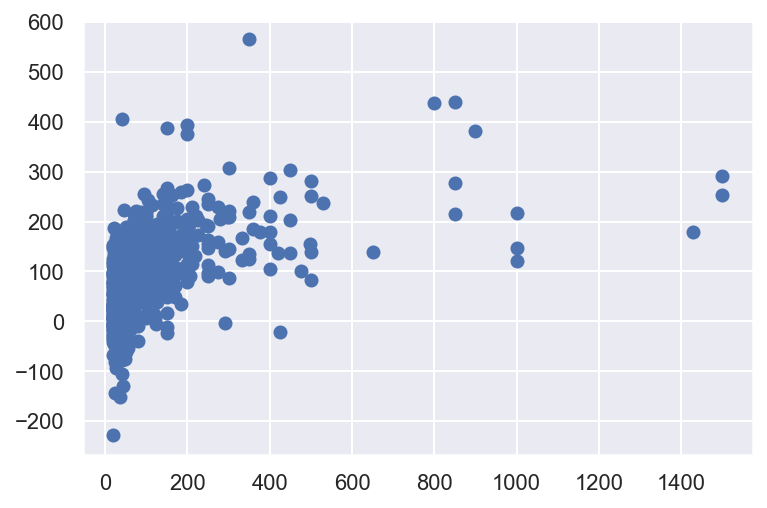

In [164]:
m1ols(X_,y_)

Seller_rating has a sizable impact on price.<br>
Record labels, blue note and Prestige seem to have some value.<br>
Keep in mind the scales are quite different.

**good for processes**
https://towardsdatascience.com/polynomial-regression-bbe8b9d97491plt.scatter(X_val, y_val, s=10)

**1b. Alt model linear regression (IGNORE)**

MSE: 15157.403774558981
MAE: 60.937970430438575
RMSE: 123.11540835557092
R2 from val_score: 0.22257561884700616
Feature coefficient results: 

xnotes : -6.31
recyear : -10.09
rating : 6.53
votes : -0.60
haves : -0.10
wants : 0.31
seller_rating : 82.72
media_cond_num : 33.18
sleeve_cond_num : 8.29
reclabel2_Atlantic  : 14.43
reclabel2_Blue Note  : 107.16
reclabel2_Columbia  : 18.17
reclabel2_Contemporary Records  : -6.66
reclabel2_EmArcy  : -24.33
reclabel2_Impulse!  : 29.06
reclabel2_Mercury  : -4.34
reclabel2_New Jazz  : 83.56
reclabel2_Other : 23.06
reclabel2_Prestige  : 56.12
reclabel2_RCA Victor  : 17.33
reclabel2_Riverside Records  : 19.29
reclabel2_Vee Jay Records  : 24.49
reclabel2_Verve Records  : 4.64


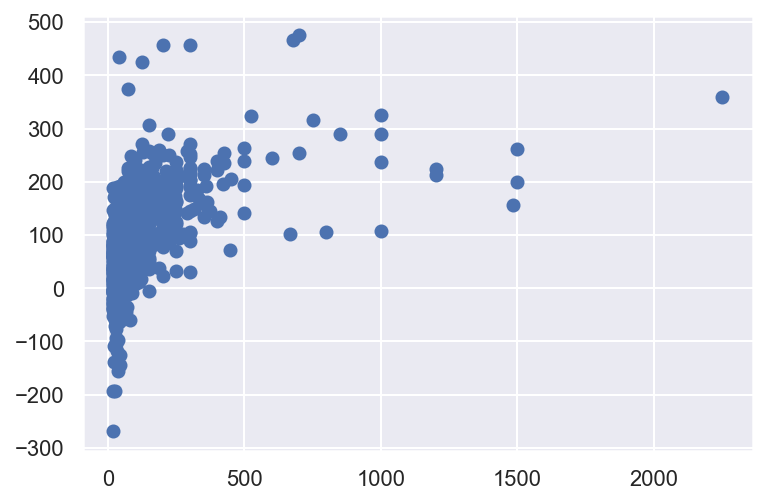

In [165]:
# method 2
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2, random_state=30)


# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_val)

# score fit model on validation data
val_score = lr_model.score(X_val, y_val)
#print('R2 from val_score:',val_score)

#R2 = metrics.r2_score(y_val, y_pred)
MSE = metrics.mean_squared_error(y_val, y_pred)
MAE = metrics.mean_absolute_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
coefs=lr_model.coef_.flatten()

print('MSE:', MSE)
print('MAE:', MAE)
print('RMSE:', RMSE)
print('R2 from val_score:',val_score)
#print('R2',R2)

print('Feature coefficient results: \n')
    
predicted = lr_model.predict(X_val)
expected = y_val
plt.scatter(expected, predicted)    
    
for feature, coef in zip(X_.columns, coefs):
    print(feature, ':', f'{coef:.2f}') 


**Based on initial results we can drop votes (collinear with ratings, etc.), drop xnotes (seems like random noise) and compute division interaction (wants / haves)**

### More Feature Engineering

In [166]:
# drop columns that are noise
df4=df3.drop(['xnotes','votes','seller_rating'],axis=1)
#df4=df3 

In [167]:
# division interaction
df4['want_over_have'] = df4['wants'] / df4['haves']
#df4['want_over_have'] = df4['wants'] - df4['haves']
type(df4)

pandas.core.frame.DataFrame

In [168]:
X , y = df4.drop(['price'],axis=1), df4['price']
print(X.columns)
print(X.shape,y.shape)

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=35)

Index(['recyear', 'rating', 'haves', 'wants', 'media_cond_num',
       'sleeve_cond_num', 'reclabel2_Atlantic ', 'reclabel2_Blue Note ',
       'reclabel2_Columbia ', 'reclabel2_Contemporary Records ',
       'reclabel2_EmArcy ', 'reclabel2_Impulse! ', 'reclabel2_Mercury ',
       'reclabel2_New Jazz ', 'reclabel2_Other', 'reclabel2_Prestige ',
       'reclabel2_RCA Victor ', 'reclabel2_Riverside Records ',
       'reclabel2_Vee Jay Records ', 'reclabel2_Verve Records ',
       'want_over_have'],
      dtype='object')
(6981, 21) (6981,)


MSE: 12581.48800781428
MAE: 59.15140859749762
RMSE: 112.16723232662149
R2 0.23327690417943037


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.439
Model:                            OLS   Adj. R-squared (uncentered):              0.436
Method:                 Least Squares   F-statistic:                              165.4
Date:                Thu, 21 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:11:44   Log-Likelihood:                         -28221.
No. Observations:                4467   AIC:                                  5.648e+04
Df Residuals:                    4446   BIC:                                  5.662e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
recyear                            -6.0006      0.356    -16.873      0.000      -6.698      -5.303
rating                             12.2993      1.922      6.400      0.000       8.532      16.067
haves                              -0.1105      0.011    -10.240      0.000      -0.132      -0.089
wants                               0.2514      0.011     22.264      0.000       0.229       0.274
media_cond_num                     39.9102      2.504     15.937      0.000      35.001      44.820
sleeve_cond_num                     7.1331      2.189      3.259      0.001       2.842      11.425
reclabel2_Atlantic                 67.9630     19.374      3.508      0.000      29.980     105.946
reclabel2_Blue Note               168.6146     17.974      9.381      0.000     133.377     203.852
reclabel2_Columbia                 77.9647     18.089      4.310      0.000      42.500     113.429
reclabel2_Contemporary Records     78.6458     24.396      3.224      0.001      30.817     126.474
reclabel2_EmArcy                   66.3846     22.824      2.909      0.004      21.638     111.131
reclabel2_Impulse!                 79.6662     19.943      3.995      0.000      40.569     118.764
reclabel2_Mercury                  49.1548     25.458      1.931      0.054      -0.755      99.065
reclabel2_New Jazz                150.1805     23.860      6.294      0.000     103.404     196.957
reclabel2_Other                    82.5031     17.511      4.712      0.000      48.174     116.833
reclabel2_Prestige                120.9375     17.763      6.808      0.000      86.112     155.763
reclabel2_RCA Victor               85.6499     24.931      3.435      0.001      36.772     134.528
reclabel2_Riverside Records        86.0438     18.008      4.778      0.000      50.739     121.348
reclabel2_Vee Jay Records          98.8301     23.778      4.156      0.000      52.213     145.447
reclabel2_Verve Records            74.7894     19.761      3.785      0.000      36.049     113.530
want_over_have                     10.5759      0.836     12.655      0.000       8.938      12.214
==============================================================================
Omnibus:                     5833.451   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1470661.304
Skew:                           7.171   Prob(JB):                         0.00
Kurtosis:                      90.725   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Sta

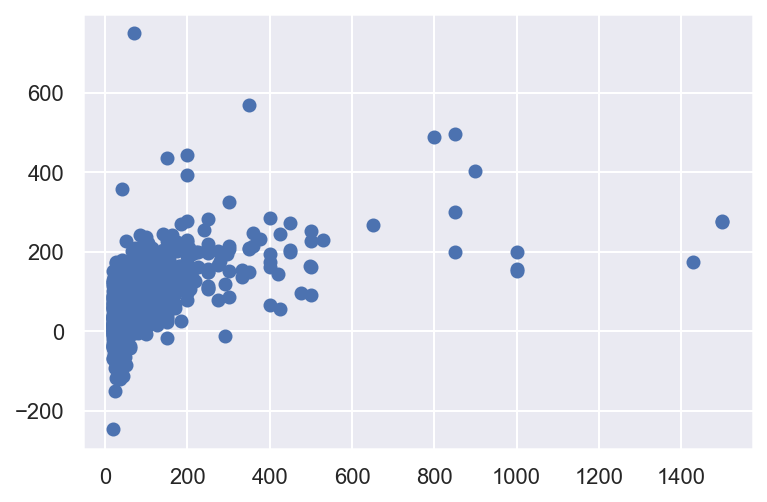

In [169]:
m1ols(X_,y_)

<br>

### Model 2. Kfold CV - no transformations, no standardization
- https://stackoverflow.com/questions/45394527/do-i-need-to-split-data-when-using-gridsearchcv#:~:text=1%20Answer&text=GridSearchCV%20will%20take%20the%20data,for%20example%20proportion%20of%20split).

**Starting DF: DF4 (dropped vars, onehotencoded)**

In [170]:
# Train+val convert to array
from sklearn.model_selection import KFold

# Keep in mind X_ has cats already transformed (full training - not val)
X_kf, y_kf = np.array(X_), np.array(y_)

Feature coefficient results: 

Feature coefficient results: 

recyear : -9.50
rating : 6.68
haves : -0.10
wants : 0.23
media_cond_num : 34.14
sleeve_cond_num : 8.81
reclabel2_Atlantic  : 7.47
reclabel2_Blue Note  : 102.70
reclabel2_Columbia  : 6.78
reclabel2_Contemporary Records  : -17.98
reclabel2_EmArcy  : -25.81
reclabel2_Impulse!  : 23.98
reclabel2_Mercury  : -9.52
reclabel2_New Jazz  : 86.50
reclabel2_Other : 14.11
reclabel2_Prestige  : 51.14
reclabel2_RCA Victor  : 11.63
reclabel2_Riverside Records  : 18.09
reclabel2_Vee Jay Records  : 30.26
reclabel2_Verve Records  : 7.47
want_over_have : 9.39
Feature coefficient results: 

Feature coefficient results: 

recyear : -9.64
rating : 7.23
haves : -0.10
wants : 0.23
media_cond_num : 36.21
sleeve_cond_num : 7.75
reclabel2_Atlantic  : 3.52
reclabel2_Blue Note  : 105.65
reclabel2_Columbia  : 0.34
reclabel2_Contemporary Records  : -8.12
reclabel2_EmArcy  : -31.89
reclabel2_Impulse!  : 23.92
reclabel2_Mercury  : -11.80
reclabel2_New Jazz  

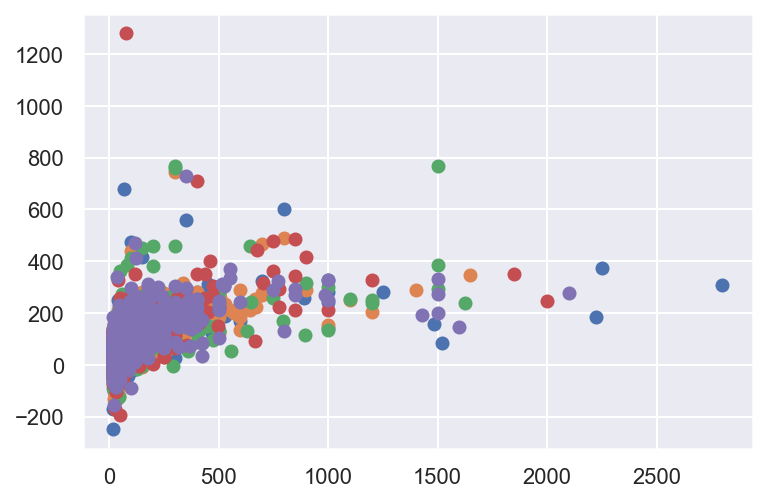

In [171]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 30)
train_lm_r2s = [] #collect the validation results
cv_lm_r2s = [] #collect the validation results
mae_lm  = []
mse_lm  =[]
rmse_lm =[]

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. get your predicted y values from the validation set
    y_pred = lm.predict(X_val)

    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    train_lm_r2s.append(round(lm.score(X_train, y_train), 3))
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''    
    
    MSE = metrics.mean_squared_error(y_val, y_pred)
    MAE = metrics.mean_absolute_error(y_val, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = metrics.r2_score(y_val, y_pred)
    
    mse_lm.append(round(metrics.mean_squared_error(y_val, y_pred),3))
    mae_lm.append(round(metrics.mean_absolute_error(y_val, y_pred),3))
    rmse_lm.append(round(np.sqrt(MSE),3))
    
#     print('MSE:', MSE)
#     print('MAE:', MAE)
#     print('RMSE:', RMSE)
#     print('R2:',R2)

    print('Feature coefficient results: \n')

    plt.scatter(y_val, y_pred)
    
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''

print('Simple regression scores (Train): ', train_lm_r2s, '\n')
print('Simple regression scores (Val): ', cv_lm_r2s, '\n')

print(f'Simple mean train cv r^2: {np.mean(train_lm_r2s):.3f} +- {np.std(train_lm_r2s):.3f}')
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')

print(f'mae lm val: {np.mean(mae_lm):.3f}')
print(f'mse lm val: {np.mean(mse_lm):.3f}')
print(f'rmse lm val: {np.mean(rmse_lm):.3f}')


<br>

### Model 3. CV no transformations, with standardization (ignore this model)

**Transforming Variables -KF CV**

In [172]:
# recrate x,y (no encodeing_)
X , y = df4.drop('price',axis=1), df2['price']
print(X.columns)
print(X.shape,y.shape)

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=35)

Index(['recyear', 'rating', 'haves', 'wants', 'media_cond_num',
       'sleeve_cond_num', 'reclabel2_Atlantic ', 'reclabel2_Blue Note ',
       'reclabel2_Columbia ', 'reclabel2_Contemporary Records ',
       'reclabel2_EmArcy ', 'reclabel2_Impulse! ', 'reclabel2_Mercury ',
       'reclabel2_New Jazz ', 'reclabel2_Other', 'reclabel2_Prestige ',
       'reclabel2_RCA Victor ', 'reclabel2_Riverside Records ',
       'reclabel2_Vee Jay Records ', 'reclabel2_Verve Records ',
       'want_over_have'],
      dtype='object')
(6981, 21) (6981,)


In [173]:
column_trans = ColumnTransformer(
    transformers= [
        ('ss',StandardScaler(), ['recyear','rating','haves','wants','media_cond_num','sleeve_cond_num',
                                'reclabel2_Blue Note ','reclabel2_Columbia ', 'reclabel2_Contemporary Records ',
       'reclabel2_EmArcy ', 'reclabel2_Impulse! ', 'reclabel2_Mercury ',
       'reclabel2_New Jazz ', 'reclabel2_Other', 'reclabel2_Prestige ',
       'reclabel2_RCA Victor ', 'reclabel2_Riverside Records ',
       'reclabel2_Vee Jay Records ', 'reclabel2_Verve Records ',
       'want_over_have'])#,
        #('ohe',OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2'])
    ],
    remainder='passthrough')
    
lr = LinearRegression()

cvmod = make_pipeline(column_trans, lr)

print(cross_val_score(cvmod, X=X_, y=y_, cv=5))
print(cross_val_score(cvmod, X=X_, y=y_, cv=5).mean())

[0.29127903 0.21163218 0.34682452 0.19305277 0.22527854]
0.2536134111654303


*model is better after standardizing/encoding*

### Model 4. Linear Regression with polyterms and interactions and standardization

In [174]:
# recrate x,y (with encodeing)
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

X , y = df4.drop('price',axis=1), df4['price']

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=30)

In [206]:
mlr = LinearRegression()

plr = PolynomialFeatures(degree=2)
# Transform vars
X_train_polylr = plr.fit_transform(X_)

slr = StandardScaler(with_mean=False)
# standardize vars
X_train_poly_scaledlr = slr.fit_transform(X_train_polylr)

mlr.fit(X_train_poly_scaledlr,y_)

mlr.score(X_train_poly_scaledlr,y_)

y_pred = mlr.predict(X_train_poly_scaledlr)


MSE = metrics.mean_squared_error(y_, y_pred)
MAE = metrics.mean_absolute_error(y_, y_pred)
RMSE = np.sqrt(MSE)
R2 = metrics.r2_score(y_, y_pred)

print("R2:",mlr.score(X_train_poly_scaledlr,y_))
print("MSE:",MSE)
print("MAE:",MAE)
print("RMSE:",RMSE)
print("R2:",R2)
# mse_lm.append(round(metrics.mean_squared_error(y_, y_pred),3))
# mae_lm.append(round(metrics.mean_absolute_error(y_, y_pred),3))
# rmse_lm.append(round(np.sqrt(MSE),3))

R2: 0.4617156036536033
MSE: 12259.554513337365
MAE: 50.68266949198822
RMSE: 110.72287258438233
R2: 0.4617156036536033


### Model 5. Lasso Regression with CV, poly/interactions, standardizations

In [198]:
X_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5584 entries, 2143 to 5925
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   recyear                          5584 non-null   int64  
 1   rating                           5584 non-null   float64
 2   haves                            5584 non-null   float64
 3   wants                            5584 non-null   float64
 4   media_cond_num                   5584 non-null   int64  
 5   sleeve_cond_num                  5584 non-null   int64  
 6   reclabel2_Atlantic               5584 non-null   uint8  
 7   reclabel2_Blue Note              5584 non-null   uint8  
 8   reclabel2_Columbia               5584 non-null   uint8  
 9   reclabel2_Contemporary Records   5584 non-null   uint8  
 10  reclabel2_EmArcy                 5584 non-null   uint8  
 11  reclabel2_Impulse!               5584 non-null   uint8  
 12  reclabel2_Mercury

In [199]:
mls = LassoCV(cv=5)

pls = PolynomialFeatures(degree=2)

X_train_polyls = pls.fit_transform(X_)

sls = StandardScaler(with_mean=False)

X_train_poly_scaledls = sls.fit_transform(X_train_polyls)

mls.fit(X_train_poly_scaledls,y_)

y_pred=mls.predict(X_train_poly_scaledls)
MAE = metrics.mean_absolute_error(y_, y_pred)

print("R^2:",mls.score(X_train_poly_scaledls,y_))
print("MAE:",MAE)
print("RMSE:",np.mean(np.sqrt(mls.mse_path_)))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12701.999784506857, tolerance: 10111.42093642245
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15647.576867446303, tolerance: 10111.42093642245
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11717.338855616748, tolerance: 10111.42093642245
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28552.167679533362, tolerance: 10414.34582740841
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38303.12520708144, tolerance: 10414.34582740841
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42815.00351142138, tolerance: 10414.34582740841
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: C

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48686.789181537926, tolerance: 10587.703806237332
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44376.07775709778, tolerance: 10587.703806237332
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38961.61624787003, tolerance: 10587.703806237332
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14706.920541986823, tolerance: 9862.332549279414
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15559.0806645751, tolerance: 9862.332549279414
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60468.36990901083, tolerance: 9862.332549279414
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: Co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23835.91715864837, tolerance: 9893.717662188246
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70750.41297639161, tolerance: 9893.717662188246
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79874.52343278378, tolerance: 9893.717662188246
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: Co

R^2: 0.46427876898752807
MAE: 48.585574446091336
RMSE: 128.29242629237388


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21658042.718764286, tolerance: 12717.692146963553
  model = cd_fast.enet_coordinate_descent(


In [ ]:
len(X_train_poly_scaledls)

In [187]:
list(zip(pls.get_feature_names(['recyear', 'rating', 'haves', 'wants', 'media_cond_num',
       'sleeve_cond_num', 'reclabel2_Atlantic ', 'reclabel2_Blue Note ',
       'reclabel2_Columbia ', 'reclabel2_Contemporary Records ',
       'reclabel2_EmArcy ', 'reclabel2_Impulse! ', 'reclabel2_Mercury ',
       'reclabel2_New Jazz ', 'reclabel2_Other', 'reclabel2_Prestige ',
       'reclabel2_RCA Victor ', 'reclabel2_Riverside Records ',
       'reclabel2_Vee Jay Records ', 'reclabel2_Verve Records ',
       'want_over_have']),mls.coef_))

[('1', 0.0),
 ('recyear', 80.42642119756826),
 ('rating', 50.169556278036524),
 ('haves', -21.76868224500852),
 ('wants', -37.693350184013006),
 ('media_cond_num', 89.7354754965828),
 ('sleeve_cond_num', 0.0),
 ('reclabel2_Atlantic ', -2.6510583502227405),
 ('reclabel2_Blue Note ', 1.2250507425622723),
 ('reclabel2_Columbia ', -6.658998319245959),
 ('reclabel2_Contemporary Records ', -0.0),
 ('reclabel2_EmArcy ', 0.0),
 ('reclabel2_Impulse! ', 0.0),
 ('reclabel2_Mercury ', 0.0),
 ('reclabel2_New Jazz ', 0.0),
 ('reclabel2_Other', -38.99103231931555),
 ('reclabel2_Prestige ', 8.837489385259092),
 ('reclabel2_RCA Victor ', -0.0),
 ('reclabel2_Riverside Records ', -0.0),
 ('reclabel2_Vee Jay Records ', -0.0),
 ('reclabel2_Verve Records ', -0.0),
 ('want_over_have', 258.0616070048635),
 ('recyear^2', 17.54147492601903),
 ('recyear rating', -93.9480261866232),
 ('recyear haves', 67.42629908077956),
 ('recyear wants', -255.46970012241582),
 ('recyear media_cond_num', -217.1209639313059),
 ('

### Model 6. Ridge Regression with CV, poly/interactions, standardizations (BEST MODEL)

In [183]:
# RIDGE
mrd = RidgeCV(store_cv_values=True,alphas=(0.1, 1.0, 10.0))

prd = PolynomialFeatures(degree=2)

# this doesn't fit the data yet. just transforms (poly,interactions)
X_train_polyrd = prd.fit_transform(X_)

srd = StandardScaler(with_mean=False)
# this doesn't fit the data yet. just transforms (poly,interactions) and scales
X_train_poly_scaledrd = srd.fit_transform(X_train_polyrd)

# this fits your model on training data and applies CV
rmod = mrd.fit(X_train_poly_scaledrd,y_)

# this applies your coef and you can obtain R2 based on validation test folds
y_pred=mrd.predict(X_train_poly_scaledrd)
MAE = metrics.mean_absolute_error(y_, y_pred)

print("R^2:",mrd.score(X_train_poly_scaledrd,y_))
print("MAE:",MAE)
#print("RMSE:",np.mean(np.sqrt(mrd.mse_path_)))
print("RMSE:",np.sqrt(mrd.cv_values_.mean()))
#rmod_score = mrd.score(X_train_poly_scaledrd,y_)

#print(rmod_score)


R^2: 0.469128376911364
MAE: 48.700066908737284
RMSE: 123.59285180741306


In [184]:
scores = cross_val_score(mrd, X_train_poly_scaledrd, y_, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 52.329 (0.787)


In [188]:
list(zip(prd.get_feature_names(['recyear', 'rating', 'haves', 'wants', 'media_cond_num',
       'sleeve_cond_num', 'reclabel2_Atlantic ', 'reclabel2_Blue Note ',
       'reclabel2_Columbia ', 'reclabel2_Contemporary Records ',
       'reclabel2_EmArcy ', 'reclabel2_Impulse! ', 'reclabel2_Mercury ',
       'reclabel2_New Jazz ', 'reclabel2_Other', 'reclabel2_Prestige ',
       'reclabel2_RCA Victor ', 'reclabel2_Riverside Records ',
       'reclabel2_Vee Jay Records ', 'reclabel2_Verve Records ',
       'want_over_have']),mrd.coef_))

[('1', 0.0),
 ('recyear', 20.042016690757464),
 ('rating', 74.68810009468325),
 ('haves', -14.942827037469215),
 ('wants', 77.91172522760462),
 ('media_cond_num', 154.96388504367587),
 ('sleeve_cond_num', 30.227317198440232),
 ('reclabel2_Atlantic ', -28.39004790402464),
 ('reclabel2_Blue Note ', 58.264668648883344),
 ('reclabel2_Columbia ', -59.38081779866076),
 ('reclabel2_Contemporary Records ', -23.40747555894677),
 ('reclabel2_EmArcy ', -0.5373327972037032),
 ('reclabel2_Impulse! ', -22.021095363766563),
 ('reclabel2_Mercury ', -20.972039345738494),
 ('reclabel2_New Jazz ', 4.624214594701698),
 ('reclabel2_Other', -73.54053847927071),
 ('reclabel2_Prestige ', -10.81721547228085),
 ('reclabel2_RCA Victor ', -20.987056390290263),
 ('reclabel2_Riverside Records ', -20.190048626612224),
 ('reclabel2_Vee Jay Records ', -23.19126956837067),
 ('reclabel2_Verve Records ', -21.13594871240997),
 ('want_over_have', 329.2956446699641),
 ('recyear^2', 118.57145050170539),
 ('recyear rating', -

<br>

### PREDICTIONS

**TEST DF - run Ridge and Lasso models**

In [189]:
mrd.score(srd.transform(prd.transform(X_test)),y_test)

0.37665546995427657

In [190]:
mls.score(sls.transform(pls.transform(X_test)),y_test)

0.3717049933260429

**using y predictors and test y, get errors and plot**

In [217]:
#from Ridge
y_pred = mrd.predict(srd.transform(prd.transform(X_test)))

R2 = metrics.r2_score(y_test, y_pred)

MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = metrics.mean_absolute_error(y_test, y_pred)

print('Ridge MSE: ', MSE)
print('Ridge RMSE: ', RMSE)
print('Ridge MAE: ', MAE)
print('Ridge R2: ', R2)

#mrd.score(srd.transform(prd.transform(X_test)),y_test)

Ridge MSE:  12153.31672329731
Ridge RMSE:  110.24208236103539
Ridge MAE:  50.807599381260175
Ridge R2:  0.37665546995427657


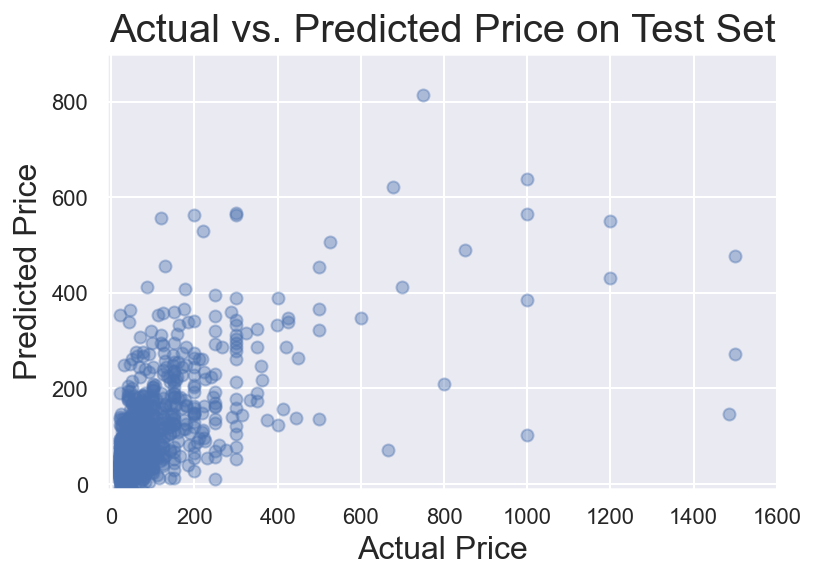

In [236]:
sns.set()
#plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=.4)
#plt.plot(np.linspace(0,1200,10), np.linspace(0,1200,10), linewidth=5, color='r')
plt.xlim(-10,1600)
plt.ylim(-10,900)
plt.xlabel('Actual Price', fontsize=16)
plt.ylabel('Predicted Price', fontsize=16)
plt.title('Actual vs. Predicted Price on Test Set', fontsize=20)

plt.savefig('y_pred.png')

**REsidual Plot**

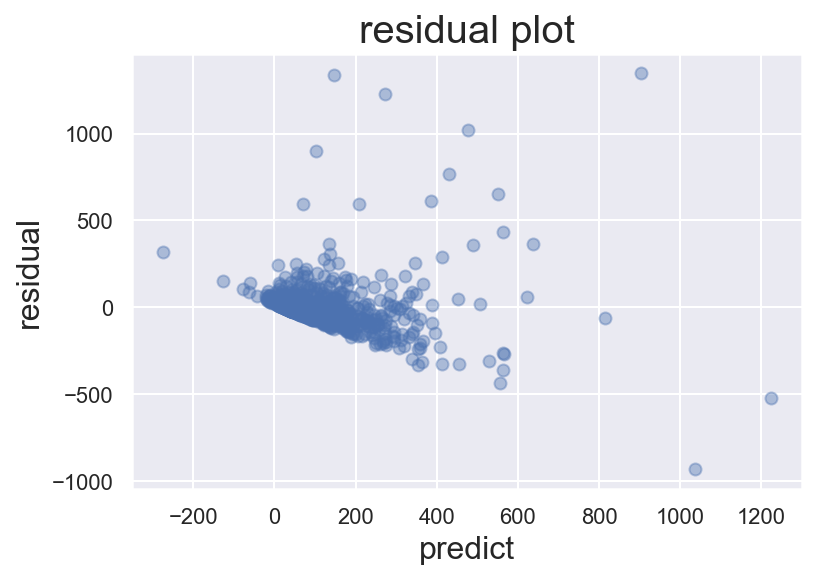

In [225]:
resid = y_test - y_pred

sns.set()
#plt.figure(figsize=(8,8))
plt.scatter(y_pred, resid, alpha=.4)

# plt.xlim(-10,1600)
# plt.ylim(-10,1000)
plt.xlabel('predict', fontsize=16)
plt.ylabel('residual', fontsize=16)
plt.title('residual plot', fontsize=20)

plt.savefig('y_resid.png')

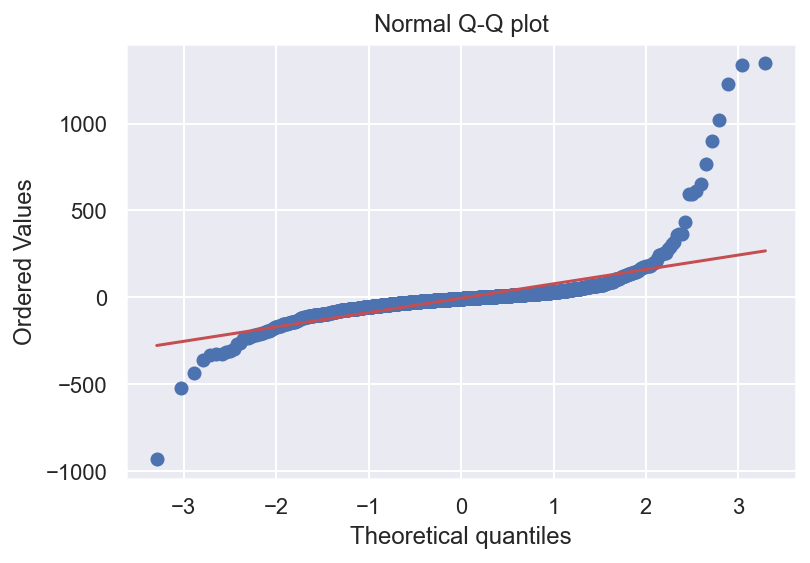

In [223]:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [228]:
print(y_pred,resid)

[ 44.87765233  77.38082616  27.60401649 ...  32.44003047  39.75847321
 110.72983113] 5895    -19.877652
2866     72.609174
1512     22.395984
2827    -30.646661
217     240.535107
           ...    
4587     46.894243
6211     14.332046
3971      7.549970
2626    145.241527
3546    -20.729831
Name: price, Length: 1397, dtype: float64


## Code below is mostly testing

### Gridsearch Lasso Regression with CV, poly/interactions, standardizations

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

alphas = np.arange(0.001,1.0,0.01) 

hyper_param_grid = {'alpha': alphas, 'fit_intercept': [True, False]}

lasso_model = GridSearchCV(Lasso(), hyper_param_grid, cv=5) # , n_jobs=-1)

lasso_model.fit(X_, y_)

In [ ]:
lasso_model.best_estimator_

In [ ]:
lasso_model.best_estimator_.score(X_,y_) # this is the same as lasso_model.score

In [ ]:
lasso_model.best_estimator_.score(X_test,y_test)

In [ ]:
#lasso_model.score(X_,y_)
scores = cross_val_score(lasso_model, X_, y_, scoring='neg_mean_absolute_error', n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))


In [ ]:
lasso_model.score(X_,y_)

### LR, Lasso, Ridge, CV - Transformations, Standardize

In [200]:
#X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.20, random_state=35)

X_kf, y_kf = np.array(X_), np.array(y_)

kf = KFold(n_splits=5, shuffle=True, random_state = 35)


In [201]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

errors_reg=[]
errors_ridge=[]
errors_lasso=[]

coeffs_reg = []

for train_index, val_index in kf.split(X_kf,y_kf):
    
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index] 
    
    lm = LinearRegression()
    lm_ridge = Ridge(alpha=0.999)
    lm_lasso = Lasso(alpha=0.1)

    
    
#     lm.fit(X_train, y_train)
#     errors_reg.append(lm.score(X_val, y_val))
#     coeffs_reg.append(lm.coef_)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.transform(X_val)
    
    
#     pls = PolynomialFeatures(degree=2)
#     X_train_poly = pls.fit_transform(X_train)
#     X_val_poly = pls.fit_transform(X_val)
    
#     sls = StandardScaler(with_mean=False)    
#     X_train_poly_scaled = sls.fit_transform(X_train_poly)
#     X_val_poly_scaled = sls.fit_transform(X_val_poly)
    
    sls = StandardScaler(with_mean=False)    
    X_train_scaled = sls.fit_transform(X_train)
    X_val_scaled = sls.fit_transform(X_val)
    
    
    lm.fit(X_train_scaled,y_train)
    errors_reg.append(lm.score(X_val_scaled, y_val))
    coeffs_reg.append(lm.coef_)

    
    lm_ridge.fit(X_train_scaled, y_train)
    errors_ridge.append(lm_ridge.score(X_val_scaled, y_val))
    
    lm_lasso.fit(X_train_scaled, y_train)
    errors_lasso.append(lm_lasso.score(X_val_scaled, y_val))    
    
print('Simple regression scores: ', errors_reg, '\n')
print('Ridge scores: ', errors_ridge, '\n')
print('Lasso scores: ', errors_lasso, '\n')

print('Mean Coeffs: ', np.mean(coeffs_reg, axis=0))


print(f'Simple mean cv r^2: {np.mean(errors_reg):.3f} +- {np.std(errors_reg):.3f}')
print(f'Ridge mean cv r^2: {np.mean(errors_ridge):.3f} +- {np.std(errors_ridge):.3f}')
print(f'Lasso mean cv r^2: {np.mean(errors_lasso):.3f} +- {np.std(errors_lasso):.3f}')

Simple regression scores:  [0.28385927334383343, 0.24703641244028285, 0.30731177166018575, 0.19705614253756654, 0.2222621347083552] 

Ridge scores:  [0.2838794970687666, 0.24712959422409664, 0.30726439148887086, 0.1970803427357175, 0.22226366348408477] 

Lasso scores:  [0.2838643674820902, 0.24831001497807992, 0.3068508286367677, 0.19705969212456542, 0.22204952246510268] 

Mean Coeffs:  [-43.17680967   7.97701716 -33.03000329  64.50048801  41.79871432
   9.9111685    1.16447839  49.83307968   3.87696575  -0.57011571
  -2.89244679   7.73372747   0.08860328  10.88631423   8.72829461
  20.66590624   1.8391431    5.58072998   3.83680901   0.93871464
  25.10481465]
Simple mean cv r^2: 0.252 +- 0.040
Ridge mean cv r^2: 0.252 +- 0.040
Lasso mean cv r^2: 0.252 +- 0.040


In [235]:
df5=df4

In [ ]:
df5.sort('')

In [ ]:
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso


rmodel = Ridge()
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=45)

prd = PolynomialFeatures(degree=2)
# this doesn't fit the data yet. just transforms (poly,interactions)
X_train_polyrd = prd.fit_transform(X_)
srd = StandardScaler(with_mean=False)
# this doesn't fit the data yet. just transforms (poly,interactions) and scales
X_train_poly_scaledrd = srd.fit_transform(X_train_polyrd)

grid=dict()
grid['alpha'] = arange(0,1,0.01)
search = GridSearchCV(rmodel, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results=search.fit(X_train_poly_scaledrd,y_)
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [ ]:
#testing

# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=50)
# define model
model= LassoCV(alphas=arange(0,1,0.01),cv=cv,n_jobs=-1)
# fit model
model.fit(X_,y_)
# summarize configuration
print('alpha: %f' % model.alpha_)

scores = cross_val_score(model, X_, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
# define model
model = Lasso(alpha=1.0)
# fit model
model.fit(X_, y_)
# define new data
# make a prediction
yhat = model.predict(X_test)
# summarize prediction
print('Predicted: %.3f' % yhat)

## TESTING
- https://github.com/allisonhonold/column_transformer_ferry_wait_blog/blob/master/columntransformer_example.ipynb
- https://towardsdatascience.com/using-columntransformer-to-combine-data-processing-steps-af383f7d5260
- https://pbpython.com/categorical-encoding.html

**using sckikit learn (works)**

In [ ]:
# column_trans = make_column_transformer(
#     (OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2']),
#     remainder='passthrough')
# lr = LinearRegression() 

column_trans = ColumnTransformer(
    transformers= [
        ('ss',StandardScaler(), ['recyear','rating','votes','haves','wants','seller_rating']),
        ('ohe',OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2'])
    ],
    remainder='passthrough')
    
#lr = LinearRegression() 

In [ ]:
lr = LinearRegression()

pipe = make_pipeline(column_trans, lr)
# pipe = Pipeline([
#             ("preprocessing", column_trans),
#             ("lr", lr)
#        ])

In [ ]:
print(cross_val_score(pipe, X=X_, y=y_, cv=5))#.mean()
print(cross_val_score(pipe, X=X_, y=y_, cv=5).mean())


#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [ ]:
print(X_.shape,y_.shape)

In [ ]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    '''
     preprocessing 
    '''
    # both one hot and continous go here. if you have issues, use iloc.
    
    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train.values)
    
    
    X_train = pd.get_dummies(X_train,drop_first=True)
    X_val   = pd.get_dummies(X_val,drop_first=True)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    
    print(X_val.shape,y_val.shape)
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    #print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    #X_cols= X.columns #flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    #for feature, coef in zip(X.columns, coefs):                
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
        

In [ ]:
split_and_validate(X_,y_)

### 4b. Add polynomial

In [ ]:
X2 = X_.copy()

X2['seller_rating2'] = X2['seller_rating'] ** 2
X2['rating2'] = X2['rating'] ** 2

In [ ]:
split_and_validate(X2,y_)

### 4c. Add interaction

In [ ]:
X3 = X_.copy()

# multiplicative interaction
X3['rate_x_vote'] = X3['rating'] * X3['votes']

# division interaction
X3['want_over_have'] = X3['wants'] / X3['haves']

In [ ]:
split_and_validate(X3,y_)

<br>

### 5. Simple Linear Model (Cross Validation)

#### Setting up for modeling and building a baseline:

In [ ]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    '''
     cc. preprocessing (standardize, one hot) -on TRAINING
     start with nums, copy array, apply one hot, run model
     right now is done on training + Val sets
    '''
    
#     X_train_ohe = pd.get_dummies(X_train)#,drop_first=True)
#     X_val_ohe   = pd.get_dummies(X_val)# ,drop_first=True)
    
#     print(X_train_ohe)
    
#     scaler = StandardScaler()    
#     X_train_s = scaler.fit_transform(X_train.values)
#     X_val_s = scaler.fit_transform(X_val.values)
    
#     X_train=pd.concat([X_train_ohe,X_train_s],axis=1)
#     X_val=pd.concat([X_val_ohe,X_val_s],axis=1)
    
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


### 5b. Polynomial model

In [ ]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    '''
     cc. preprocessing (standardize, one hot) -on TRAINING
     start with nums, copy array, apply one hot, run model
     right now is done on training + Val sets
    '''
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train.values)
    
    
    
    ''' 
    #poly with degree 2
    poly = PolynomialFeatures(degree=2)
    
    
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    
    lm_poly.fit(X_train_poly, y_train)
    cv_lm_poly_r2s.append(round(lm_poly.score(X_val_poly, y_val), 3))
    
print('Poly scores: ', cv_lm_poly_r2s, '\n')

print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')
    '''
    
    
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [ ]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    '''
     preprocessing 
    '''
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    #X_cols= X.columns #flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    #for feature, coef in zip(X.columns, coefs):                
    for feature, coef in zip(X_df.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
        #list(map('{:.2f}%'.format,x))

**Starting DF: DF4 (dropped vars, onehotencoded)**

In [ ]:
# Train+val convert to array
from sklearn.model_selection import KFold

# Keep in mind X_ has cats already transformed (full training - not val)
X_kf, y_kf = np.array(X_), np.array(y_)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X_kf, y_kf, test_size=.2, random_state=42)
#kf = KFold(n_splits=5, shuffle=True, random_state = 35)

In [ ]:
params = {'fit_intercept':[True,False]}
lr_model = GridSearchCV(LinearRegression(),params, cv=5)
lr_model.fit(X_kf, y_kf)

In [ ]:
lr_model.best_estimator_.score(X_kf, y_kf)

In [ ]:
predicted = lr_model.predict(X_kf)
expected = y_kf
#MAE = metrics.mean_absolute_error(y_kf, y_pred)
print("RMSE: %s" % np.sqrt(np.mean((predicted - expected) ** 2))) 

In [ ]:
plt.scatter(expected, predicted)

*model is a little better after CV*

In [ ]:
**Starting DF: DF4 (dropped vars, onehotencoded)**

# Train+val convert to array
from sklearn.model_selection import KFold

# Keep in mind X_ has cats already transformed (full training - not val)
X_kf, y_kf = np.array(X_), np.array(y_)

#X_train, X_val, y_train, y_val = train_test_split(X_kf, y_kf, test_size=.2, random_state=42)
#kf = KFold(n_splits=5, shuffle=True, random_state = 35)

params = {'fit_intercept':[True,False]}
lr_model = GridSearchCV(LinearRegression(),params, cv=5)
lr_model.fit(X_kf, y_kf)

lr_model.best_estimator_.score(X_kf, y_kf)

predicted = lr_model.predict(X_kf)
expected = y_kf
#MAE = metrics.mean_absolute_error(y_kf, y_pred)
print("RMSE: %s" % np.sqrt(np.mean((predicted - expected) ** 2))) 

plt.scatter(expected, predicted)

*model is a little better after CV*

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 35)
train_lm_r2s = [] #collect the validation results
cv_lm_r2s = [] #collect the validation results
mae_lm  = []
mse_lm  =[]
rmse_lm =[]

X_kf, y_kf = np.array(X_), np.array(y_)

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]    
    X_val, y_val = X_kf[val_ind], y_kf[val_ind] 
    
    
    mlr = LinearRegression()
    plr = PolynomialFeatures(degree=2)
    
    # Transform vars
    X_train_polylr = plr.fit_transform(X_train)
    X_val_train_polylr = plr.fit_transform(X_val)
    
    slr = StandardScaler(with_mean=False)
    
    # standardize vars
    X_train_poly_scaledlr = slr.fit_transform(X_train_polylr)
    X_val_train_poly_scaledlr = slr.fit_transform(X_val_train_polylr)
    
    mlr.fit(X_train_poly_scaledlr,y_train)
    
    # cc. get your predicted y values from the validation set
    
    mlr.score(X_val_train_poly_scaledlr,y_val)
    y_pred = mlr.predict(X_val_train_poly_scaledlr)
    
    
    train_lm_r2s.append(round(mlr.score(X_train_poly_scaledlr, y_train), 3))
    cv_lm_r2s.append(round(mlr.score(X_val_train_poly_scaledlr, y_val), 3))
    
    
    '''
    Obtain the coeff per features
    '''    
    
    MSE = metrics.mean_squared_error(y_val, y_pred)
    MAE = metrics.mean_absolute_error(y_val, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = metrics.r2_score(y_val, y_pred)
    
    mse_lm.append(round(metrics.mean_squared_error(y_val, y_pred),3))
    mae_lm.append(round(metrics.mean_absolute_error(y_val, y_pred),3))
    rmse_lm.append(round(np.sqrt(MSE),3))
    
#     print('MSE:', MSE)
#     print('MAE:', MAE)
#     print('RMSE:', RMSE)
#     print('R2:',R2)

    print('Feature coefficient results: \n')

    plt.scatter(y_val, y_pred)
    
    #needed to flatten the array
    coefs=mlr.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''

print('Simple regression scores (Train): ', train_lm_r2s, '\n')
print('Simple regression scores (Val): ', cv_lm_r2s, '\n')

print(f'Simple mean train cv r^2: {np.mean(train_lm_r2s):.3f} +- {np.std(train_lm_r2s):.3f}')
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')

print(f'mae lm val: {np.mean(mae_lm):.3f}')
print(f'mse lm val: {np.mean(mse_lm):.3f}')
print(f'rmse lm val: {np.mean(rmse_lm):.3f}')


## 4. Intermediate feature engineering: categories and features derived from category aggregates 

**Categorical conversions:**

- sleeve / media conditions: Can change to ordinal ranks
- artist rankings: Can rank artists based on frequency of list
- reclabel: may need to bin depending
- country: may need to bin
- pressed by: may need to bin
- recoreded at: may need to bin
- style: may or may not use
- notes: if we get notes, parse out keywords and turn into booleans:
    . first, 1st, second, 2nd, original, rare, deep groove